Load Julia packages (libraries) needed

In [1]:
using StatisticalRethinking
using StatsFuns, Optim, Turing, Flux.Tracker

Turing.setadbackend(:reverse_diff)

loaded


┌ Warning: Package Turing does not have CmdStan in its dependencies:
│ - If you have Turing checked out for development and have
│   added CmdStan as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Turing
│ Loading CmdStan into Turing from project dependency, future warnings for Turing are suppressed.
└ @ nothing nothing:840


:reverse_diff

### snippet 2.6t

Define the data

In [2]:
k = 6
n = 9

9

Define the model

In [3]:
@model globe_toss(n, k) = begin
  theta ~ Beta(1, 1) # prior
  k ~ Binomial(n, theta) # model
  return k, theta
end

globe_toss (generic function with 3 methods)

Compute the "maximum_a_posteriori" value

Set search bounds

In [4]:
lb = [0.0]
ub = [1.0]

1-element Array{Float64,1}:
 1.0

Create (compile) the model

In [5]:
model = globe_toss(n, k)

globe_toss_model (generic function with 4 methods)

Compute the maximum_a_posteriori

In [6]:
result = maximum_a_posteriori(model, lb, ub)

Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.5978593965595818]
 * Minimizer: [0.6666666666252682]
 * Minimum: 1.297811e+00
 * Iterations: 3
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 2.29e-08 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 8.38e-15 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 9.34e-10 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 43
 * Gradient Calls: 43

Use Turing mcmc

In [7]:
chn = sample(model, NUTS(1000, 0.65))

┌ Info: [Turing] looking for good initial eps...
└ @ Turing /Users/rob/.julia/packages/Turing/pRhjG/src/samplers/support/hmc_core.jl:246
[NUTS{Any}] found initial ϵ: 0.8
└ @ Turing /Users/rob/.julia/packages/Turing/pRhjG/src/samplers/support/hmc_core.jl:291
[NUTS] Sampling...  0%  ETA: 1:36:04
  ϵ:         0.8
  α:         0.874723928066178
4m  pre_cond:  [1.0]┌ Info:  Adapted ϵ = 1.2032938867347105, std = [1.0]; 500 iterations is used for adaption.
└ @ Turing /Users/rob/.julia/packages/Turing/pRhjG/src/samplers/adapt/adapt.jl:91





[NUTS] Finished with
  Running time        = 6.000263070999991;
  #lf / sample        = 0.005;
  #evals / sample     = 6.16;
  pre-cond. metric    = [1.0].


[NUTS] Sampling...100% Time: 0:00:06


Turing.Chain{AbstractRange{Int64}}(0.0, Turing.Sample[Sample(0.001, Dict{Symbol,Any}(:lf_num=>5,:elapsed=>3.98542,:epsilon=>0.8,:theta=>0.829264,:lp=>-3.95025,:eval_num=>22,:lf_eps=>0.8)), Sample(0.001, Dict{Symbol,Any}(:lf_num=>0,:elapsed=>1.757,:epsilon=>12.0375,:theta=>0.861979,:lp=>-4.53025,:eval_num=>4,:lf_eps=>12.0375)), Sample(0.001, Dict{Symbol,Any}(:lf_num=>0,:elapsed=>0.000389347,:epsilon=>2.93602,:theta=>0.861979,:lp=>-4.53025,:eval_num=>4,:lf_eps=>2.93602)), Sample(0.001, Dict{Symbol,Any}(:lf_num=>0,:elapsed=>0.000196767,:epsilon=>0.455737,:theta=>0.861979,:lp=>-4.53025,:eval_num=>4,:lf_eps=>0.455737)), Sample(0.001, Dict{Symbol,Any}(:lf_num=>0,:elapsed=>0.000173079,:epsilon=>1.00725,:theta=>0.831134,:lp=>-3.97853,:eval_num=>4,:lf_eps=>1.00725)), Sample(0.001, Dict{Symbol,Any}(:lf_num=>0,:elapsed=>0.000167725,:epsilon=>2.61322,:theta=>0.766502,:lp=>-3.24894,:eval_num=>4,:lf_eps=>2.61322)), Sample(0.001, Dict{Symbol,Any}(:lf_num=>0,:elapsed=>0.000163174,:epsilon=>7.40422,:th

Look at the generated draws (in chn)


Summary Stats:

2-element Array{Float64,1}:
 0.6847701766954662
 0.6998459047144399


Mean:           0.634881
Minimum:        0.185820
1st Quartile:   0.544115
Median:         0.641517
3rd Quartile:   0.741997
Maximum:        0.937363
Length:         1000
Type:           Float64




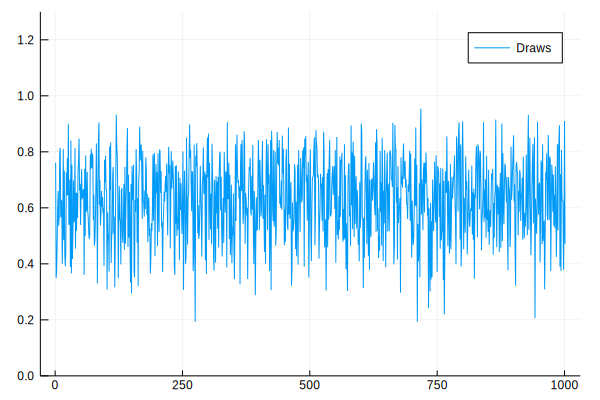

In [8]:
println()
describe(chn[:theta])
println()
MCMCChain.hpd(chn[:theta], alpha=0.945) |> display
println()

p_grid = range(0, step=0.001, stop=1)
prior = ones(length(p_grid))
likelihood = [pdf(Binomial(9, p), 6) for p in p_grid]
posterior = likelihood .* prior
posterior = posterior / sum(posterior)
samples = sample(p_grid, Weights(posterior), length(p_grid))

p = Vector{Plots.Plot{Plots.GRBackend}}(undef, 2)
p[1] = plot(1:length(p_grid), samples, markersize = 2, ylim=(0.0, 1.3), lab="Draws")

Analytical calculation

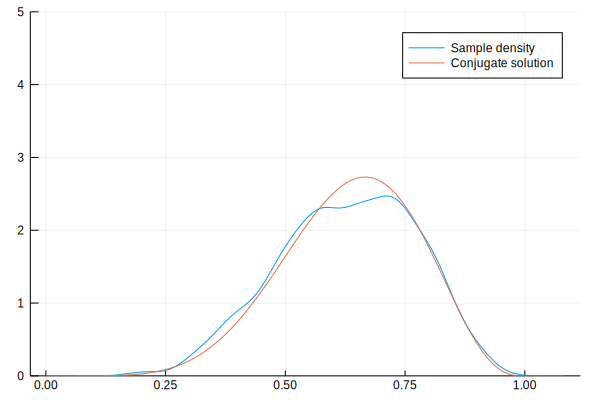

In [9]:
w = 6
n = 9
x = 0:0.01:1
p[2] = density(samples, ylim=(0.0, 5.0), lab="Sample density")
plot!(p[2], x, pdf.(Beta( w+1 , n-w+1 ) , x ), lab="Conjugate solution")

Quadratic approximation

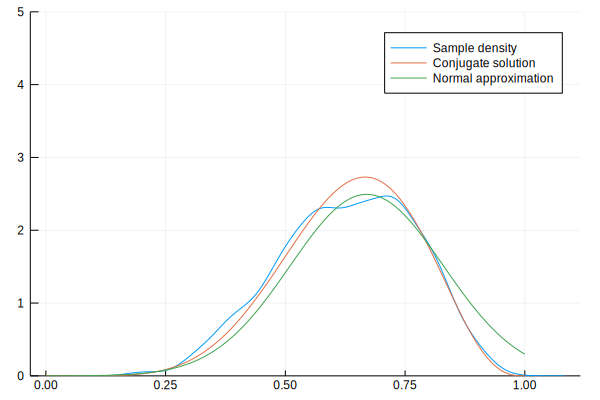

In [10]:
plot!( p[2], x, pdf.(Normal( 0.67 , 0.16 ) , x ), lab="Normal approximation")

Show plots

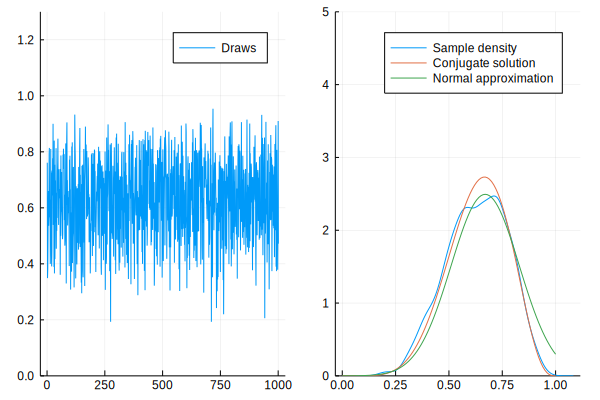

In [11]:
plot(p..., layout=(1, 2))

### snippet 2.7

analytical calculation

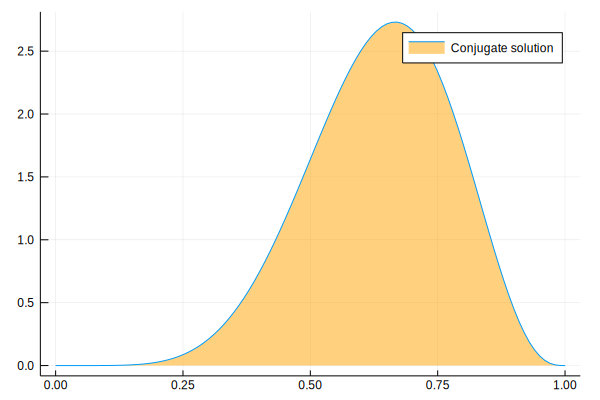

In [12]:
w = 6
n = 9
x = 0:0.01:1
plot( x, pdf.(Beta( w+1 , n-w+1 ) , x ), fill=(0, .5,:orange), lab="Conjugate solution")

quadratic approximation

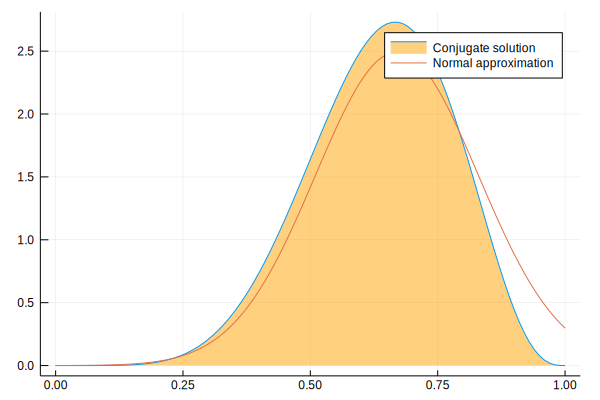

In [13]:
plot!( x, pdf.(Normal( 0.67 , 0.16 ) , x ), lab="Normal approximation")

Turing Chain

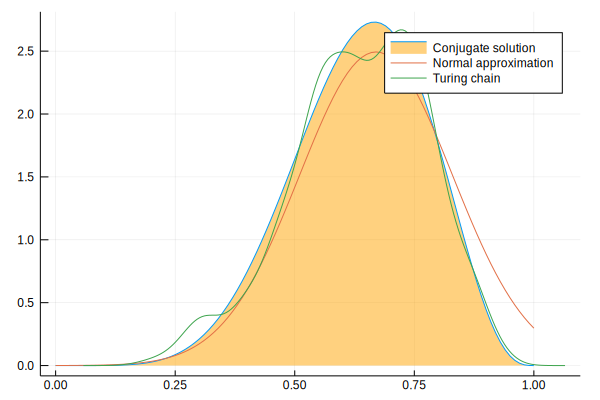

In [14]:
density!(chn[:theta], lab="Turing chain")

### snippet 2.8

The example is in `stan_globe_toss.jl`. It will be in `clips_02_08_08s.jl`.

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*